In [1]:
library(Seurat)
library(ComplexHeatmap)
library(circlize)
library(dplyr)
library(tibble)
library(viridis)
source("./heatmap.fun.R")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))



Attaching package: ‘dplyr’


The following objec

In [2]:
## Data for visualization
seu <- readRDS(file = paste0("./load_files/ExN.harmony.spread_region.v1.harmony.rds"))
nseu <- seu[, seu@meta.data$cbnage %in% c("E62-64", "E77-78") & 
            seu@meta.data$subtype %in% c("ExN deep NR4A2 GRID2", "ExN deep SYT6")]
nseu@meta.data$avg_cls <- paste0(nseu@meta.data$lobe, "|", nseu@meta.data$subtype)
kp_cls <- table(nseu@meta.data$avg_cls) %>% .[. >= 15] %>% names()
seu_use <- subset(nseu, avg_cls %in% kp_cls)
rm(seu, nseu)

In [3]:
marAvgFile <- "./Horizontal_gradient_deep_avg_markers.Rdata"
if (!file.exists(marAvgFile)){
    ## average expression
    Idents(seu_use) <- "avg_cls"
    avgs <- log(AverageExpression(seu_use)$RNA + 1)

    ## find region-specific genes
    Idents(seu_use) <- "region"
    mar_res <- FindAllMarkers(seu_use, max.cells.per.ident = 500, logfc.threshold = 0.3, only.pos = TRUE) %>%
                mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01))
    mars <- mar_res %>%
                filter(ratio_fc >= 1.25 & pct.1 >= 0.15 & p_val_adj <= 0.01) %>%
                .$gene %>% unique()
    save(avgs, mars, file = marAvgFile)
}
load(file = marAvgFile)
summary(mars)
mars

   Length     Class      Mode 
      123 character character 

[1] "SATB2"        "SATB1"        "TSC22D1"      "PCDH10"       "VCAN"        
  [6] "RGMA"         "KCTD12"       "PCDH17"       "CLMP"         "DAAM1"       
 [11] "AKAP7"        "LMO3"         "FBXW7"        "PCP4"         "FABP7"       
 [16] "ZNF385D"      "LMO4"         "AP1S2"        "ALCAM"        "TMEM178A"    
 [21] "SORCS1"       "ELMO1"        "ROBO1"        "SYT1"         "ATP2B1"      
 [26] "PPP1R1B"      "IGFBP5"       "LSAMP"        "PPP2R1B"      "NOVA1"       
 [31] "LOC114671387" "WLS"          "GPR22"        "NAV1"         "NRCAM"       
 [36] "ID2"          "SPOCK1"       "LOC114678346" "NPY1R"        "CYP26A1"     
 [41] "NETO2"        "TLE4"         "BTG1"         "CHL1"         "TCEAL2"      
 [46] "MTHFD2L"      "SYNPR"        "FKBP7"        "PALM2"        "HSPB1"       
 [51] "DUSP4"        "CSRP2"        "TRIM36"       "ETV1"         "PKP4"        
 [56] "MTUS1"        "SRGAP1"       "LRATD1"       "FAM155A"      "RND3"        
 [61] "GABRA5"       "PRTFDC1"      "OCIAD2"       "ATP1B1"       "DNER"        
 [66] "TMSB15B.1"    "KLHL5"        "RHOBTB3"      "MPPED1"       "CISD1"       
 [71] "OSBPL1A"      "IRF2BP2"      "NBEA"         "ARPP21"       "LOC100427153"
 [76] "GPR85"        "RGS17"        "LOC114678801" "DCLK1"        "RAC3"        
 [81] "NR4A2"        "TMEFF1"       "HS3ST4"       "POU3F2"       "KHDRBS3"     
 [86] "PLXDC2"       "PITPNC1"      "GUCY1A2"      "LHFPL6"       "TENM2"       
 [91] "RUNX1T1"      "SIPA1L2"      "WNT7B"        "FHL2"         "CRYM"        
 [96] "RBPJ"         "C14H11orf96"  "SHISA6"       "VSNL1"        "RSPO3"       
[101] "NR2F2"        "SLN"          "TENM3"        "ITM2B"        "NR2F1"       
[106] "SIAH3"        "CAV1"         "CAMK4"        "PLK2"         "HSF2BP"      
[111] "AUTS2"        "NOL4"         "GNG3"         "ACTR3B"       "CNTFR"       
[116] "PRKCB"        "GPX1"         "SLF1"         "LOC707085"    "PFN1"        
[121] "CHGA"         "MN1"          "CBLB"

 ..cutHeight not given, setting it to 8.92  ===>  99% of the (truncated) height range in dendro.
 ..done.


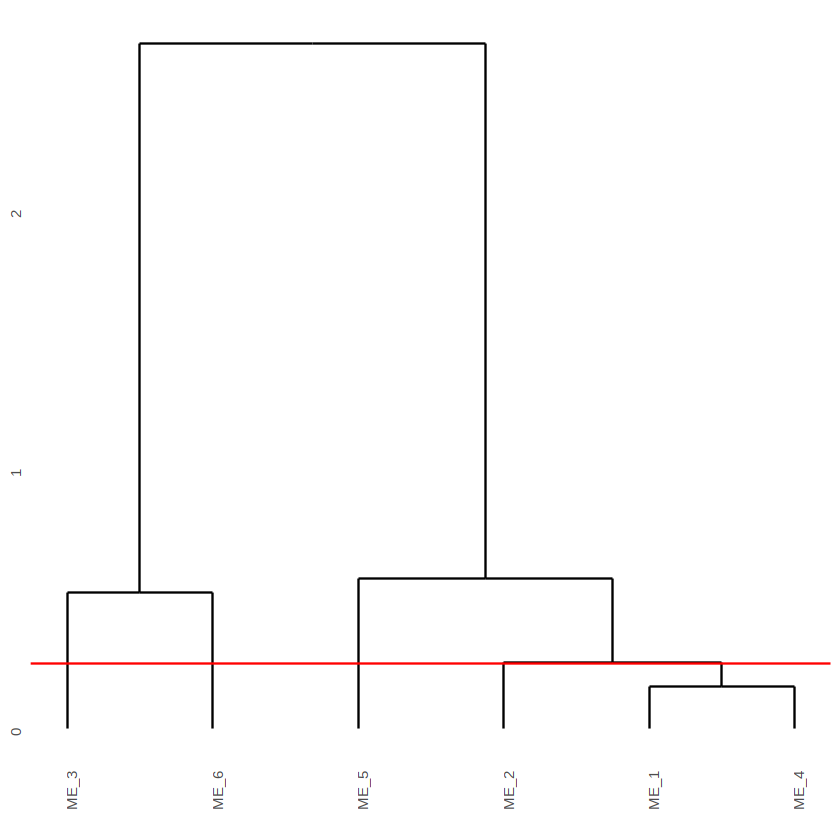

In [4]:
## Scale average expression & clustering
scale_avg <- avgs[mars, ,drop = FALSE] %>%
            as.matrix() %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 2.5)

mod_res <- get_modules(data = scale_avg, 
                       gene_use = NULL, 
                       minClusterSize = 10, 
                       tree.method = "ward.D2", 
                       sensitivity = 3, cor_method = "p", 
                       file_name = "Circle_mod_deep")

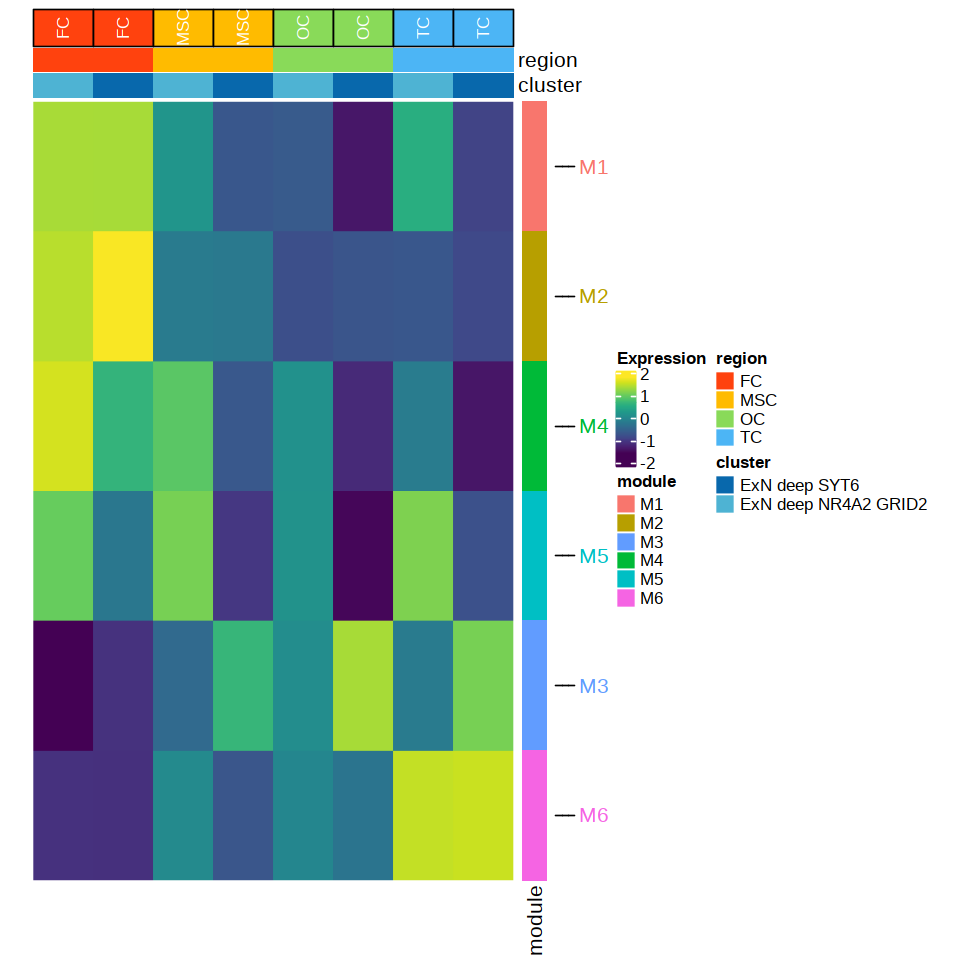

In [5]:
## Order modules based on module eigengenes
mes <- mod_res$mes %>%
                as.matrix() %>%
                MinMax(., min = -1.5, max = 1.75) ##5%, 95%
all_regs <- c("FC", "MSC", "OC", "TC")
mod_ord <- paste0("ME_", c(1,2,4,5,3,6))
mes <- mes[mod_ord, paste0(rep(all_regs, each = 2), "|", rep(c("ExN deep NR4A2 GRID2", "ExN deep SYT6"), 4))]
mes_vis <- mes
rownames(mes_vis) <- gsub("E_", "", rownames(mes_vis))


ht_mes <- plot_heatmap.end(mat = mes_vis, 
                 label_genes = rownames(mes_vis), 
                 color_breaks = seq(-1.5, 1.75, 0.25), 
                 module_labs = rownames(mes_vis))

options(repr.plot.width=8, repr.plot.height=8)
draw(ht_mes)

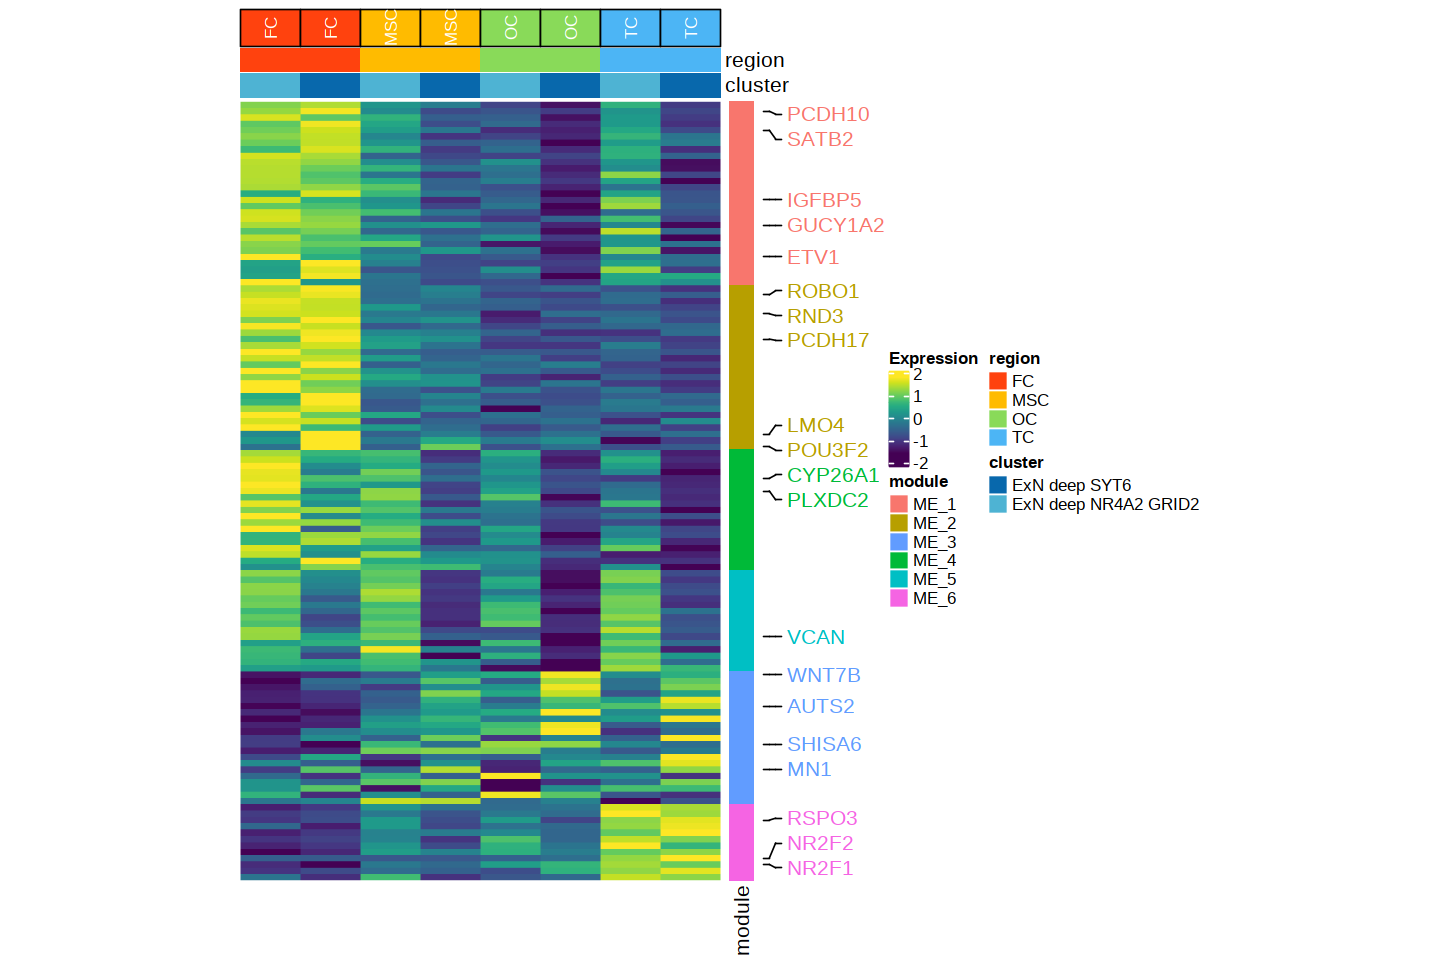

In [6]:
## Order genes based on their module membership
vis_avg <- avgs[mars, ,drop = FALSE] %>%
            as.matrix() %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 1.75)
all_regs <- c("FC", "MSC", "OC", "TC")
vis_avg <- vis_avg[, paste0(rep(all_regs, each = 2), "|", rep(c("ExN deep NR4A2 GRID2", "ExN deep SYT6"), 4))]


gene_ord <- lapply(rownames(mes), function(mod) {
            sub_meta <- filter(mod_res$gene_meta, module == mod)
            mm <- setNames(sub_meta$mm, sub_meta$gene)
            names(mm)[order(mm, decreasing = TRUE)]
            }) %>%
            unlist() %>%
            unique()
sel_genes <- c("PCDH10", "SATB2", "IGFBP5", "GUCY1A2", "ETV1", "PCDH17", 
               "ROBO1", "POU3F2", "RND3", "LMO4", "POU3F2", "CYP26A1",  
               "PLXDC2", "NR2F1", "NR2F2", "PLXDC2", "PCDH17", "VCAN", 
               "RSPO3", "WNT7B", "AUTS2", "MN1", "SHISA6") %>% unique()
ht_expr <- plot_heatmap.end(mat = vis_avg[gene_ord, ], 
                 label_genes = sel_genes, 
                 color_breaks = seq(-1.5, 1.75, 0.25), 
                 module_labs = mod_res$gene_meta$module[match(gene_ord, mod_res$gene_meta$gene)])
options(repr.plot.width=12, repr.plot.height=8)
draw(ht_expr)

In [7]:
pdf("./report/genegradients_deep.v2.pdf", width = 12, height = 5)
ht_expr <- plot_heatmap.end(mat = vis_avg[gene_ord, ], 
                 label_genes = sel_genes, 
                 color_breaks = seq(-1.5, 1.75, 0.25), 
                 module_labs = mod_res$gene_meta$module[match(gene_ord, mod_res$gene_meta$gene)])
draw(ht_expr)
dev.off()

png 
  2

In [8]:
## Save data
save(avgs, mod_ord, gene_ord, scale_avg, vis_avg, mod_res, 
     file = paste0("./load_files/", "Horizontal_mod_deep_res_v2.Rdata"))

In [9]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scatterpie_0.1.5      foreach_1.5.0         ggpubr_0.3.0         
 [4] ggplot2_3.3.0         GetoptLong_0.1.8      WGCNA_1.69           
 [7] fastcluster_1.1.25    dynamicTreeCut_1.63-1 viridis_0.5.1        
[10] viridisLite_0.3.0  